In [ ]:
import pandas as pd
pd.set_option('display.width',1000)
pd.set_option('display.max_columns',None)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats

Данный датасет был взят из программы учебного курса "Инженер машинного обучения" от Karpov Courses. 

Перед нами датасет, который содержит информацию о сделках займа определенными организациями (без уточнения какими). Задача заключается в том, чтобы научиться предсказывать дефолт по сделке (неисполнение обязательств). Давайте найдем оптимальный алгоритм для решения этой задачи. Датасет имеет следующие колонки:
- Deal_id - id сделки
- Deal_date - дата сделки
- First_deal_date - дата первой сделки клиента
- Secret_info_1 - засекреченная информация №1
- Secret_info_2 - засекреченная информация №2
- Secret_info_3 - засекреченная информация №3
- First_default_date - дата первого дефолта клиента
- Successful_deals_count - количество успешно завершенных сделок клиентом, до текущей сделки
- Region - регион
- institution - организация, предоставляющая займ
- Hashed_deal_detail_1 - хешированные детали сделки №1
- Hashed_deal_detail_2 - хешированные детали сделки №2
- Hashed_deal_detail_3 - хешированные детали сделки №3
- Hashed_deal_detail_4 - хешированные детали сделки №4
- Hashed_deal_detail_5 - хешированные детали сделки №5
- Hashed_deal_detail_6 - хешированные детали сделки №6
- Age - возраст клиента
- Gender - пол клиента
- Default - ситуация дефолта

Загрузим датасет и посмотрим на его размер

In [632]:
df = pd.read_csv('dataset.csv')
len(df)

3168

### EDA

Первым делом давайте посмотрим на доступный нам датасет через метод describe()

In [633]:
df.describe()

,Deal_id,Secret_info_1,Secret_info_2,Secret_info_3,Successful_deals_count,institution,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Default
count,3.168000e+03,535.000000,535.000000,535.000000,3154.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.0,3168.000000,3168.000000
mean,4.605727e+07,3.935514,-2.299065,5.267290,1.043754,13.350694,2.518939,-2.404356,8.462437,3.193813,-2.981692,5.0,36.411616,0.110795
std,5.370953e+07,0.888467,0.734579,0.498645,1.649416,8.851891,0.351308,2.474564,3.521127,2.048743,0.245540,0.0,10.821444,0.313928
min,5.856790e+05,2.500000,-3.000000,5.000000,0.000000,2.000000,2.500000,-3.000000,5.000000,2.500000,-3.000000,5.0,20.000000,0.000000
25%,2.761608e+07,3.500000,-3.000000,5.000000,0.000000,7.000000,2.500000,-3.000000,6.000000,2.500000,-3.000000,5.0,28.000000,0.000000
50%,4.349426e+07,3.500000,-2.000000,5.000000,0.000000,8.000000,2.500000,-3.000000,8.000000,2.500000,-3.000000,5.0,34.000000,0.000000
75%,5.778544e+07,4.500000,-2.000000,5.000000,2.000000,15.000000,2.500000,-3.000000,10.000000,2.500000,-3.000000,5.0,43.000000,0.000000
max,6.927701e+08,9.500000,2.000000,8.000000,17.000000,58.000000,17.500000,78.000000,29.000000,37.500000,4.000000,5.0,72.000000,1.000000


Обнаружены пропуски в 4 признаках: `Secret_info_1`, `Secret_info_2`, `Secret_info_3` и `Successful_deals_count` (количество записей с непустыми значениями меньше общего числа строк 3168). Рассмотрим подробнее признак `Successful_deals_count`, отражающий количество успешных сделок. Хотя для числовых данных часто используют заполнение средними значениями, сначала проанализируем распределение уникальных значений для выбора оптимальной стратегии.

In [634]:
df['Successful_deals_count'].value_counts(dropna=False), df['Successful_deals_count'].value_counts(dropna=False, normalize=True)

(Successful_deals_count
 0.0     1903
 2.0      592
 3.0      244
 1.0      194
 4.0      105
 5.0       52
 6.0       23
 NaN       14
 7.0       13
 8.0        9
 9.0        8
 10.0       6
 17.0       2
 12.0       2
 11.0       1
 Name: count, dtype: int64,
 Successful_deals_count
 0.0     0.600694
 2.0     0.186869
 3.0     0.077020
 1.0     0.061237
 4.0     0.033144
 5.0     0.016414
 6.0     0.007260
 NaN     0.004419
 7.0     0.004104
 8.0     0.002841
 9.0     0.002525
 10.0    0.001894
 17.0    0.000631
 12.0    0.000631
 11.0    0.000316
 Name: proportion, dtype: float64)

Анализ показывает, что в колонке 14 пропусков, а наиболее частое значение - 0 (60% наблюдений). По смыслу признака `Successful_deals_count` пропуск логично интерпретировать как отсутствие сделок, то есть 0. Поэтому, хотя обычно для числовых данных используют средние значения, в данном случае целесообразнее заполнить пропуски нулями.

In [635]:
df['Successful_deals_count'] = df['Successful_deals_count'].fillna(0)

Теперь выясним, а может ли кол-во сделок как-то успешно объяснить таргет?

<Axes: xlabel='Default', ylabel='Successful_deals_count'>

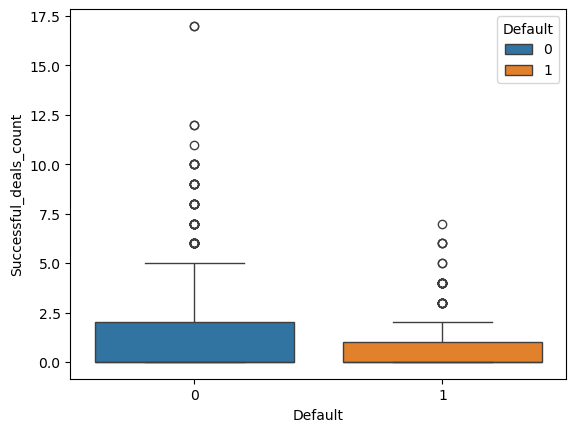

In [636]:
sns.boxplot(data = df, x = df['Default'].astype('category'), y = 'Successful_deals_count', hue =df['Default'] )

Видим что дефолтящие кленты в основном имеют меньшее кол-во успешных сделок. Признак однозначно важный.
Теперь рассмотрим остальные колонки с `NaN`.

In [637]:
df['Secret_info_1'].value_counts(dropna=False)

Secret_info_1
NaN    2633
3.5     384
4.5      89
5.5      39
6.5      11
2.5       4
7.5       4
8.5       3
9.5       1
Name: count, dtype: int64

Засекреченный признак `Secret_info_1` довольно интересный. С одной стороны всего 8 возможных значений, что намекает на то, что это скорее всего категориальный признак. С другой стороны запись в формате число + 0,5 необычно, что могло бы указывать на то, что эта колонка может быть вещественной. Давайте рассмотрим влияние данных признаков (`Secret_info_1`,`Secret_info_2`,`Secret_info_3`) на таргет.

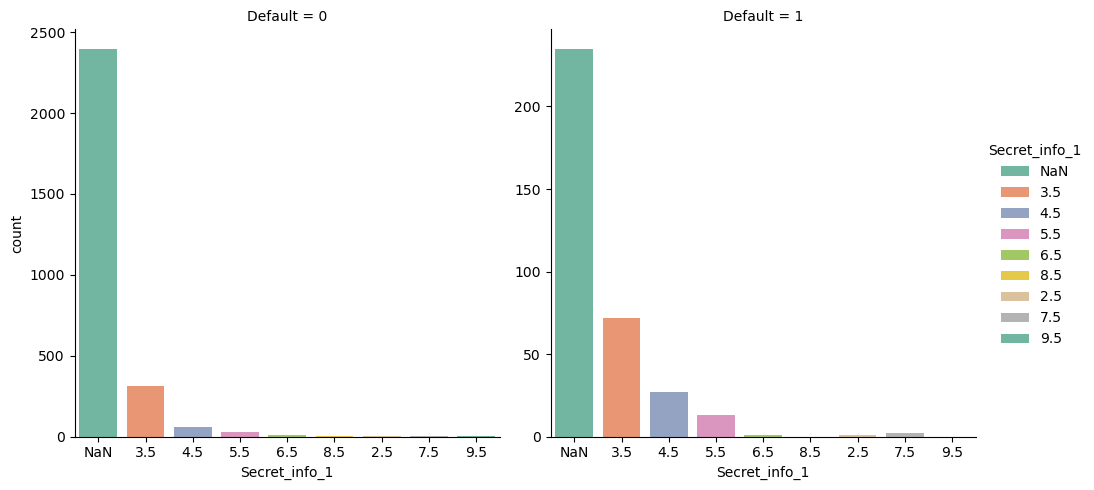

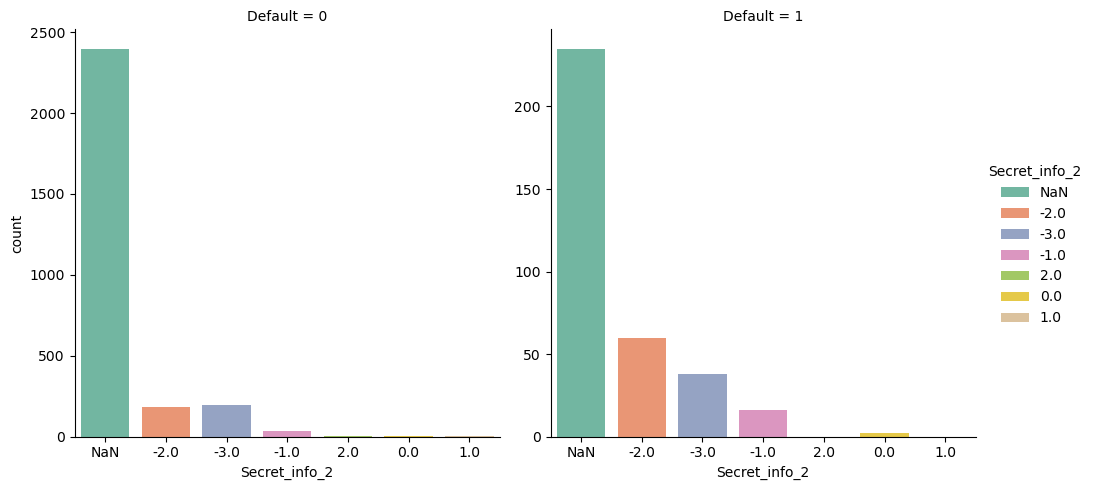

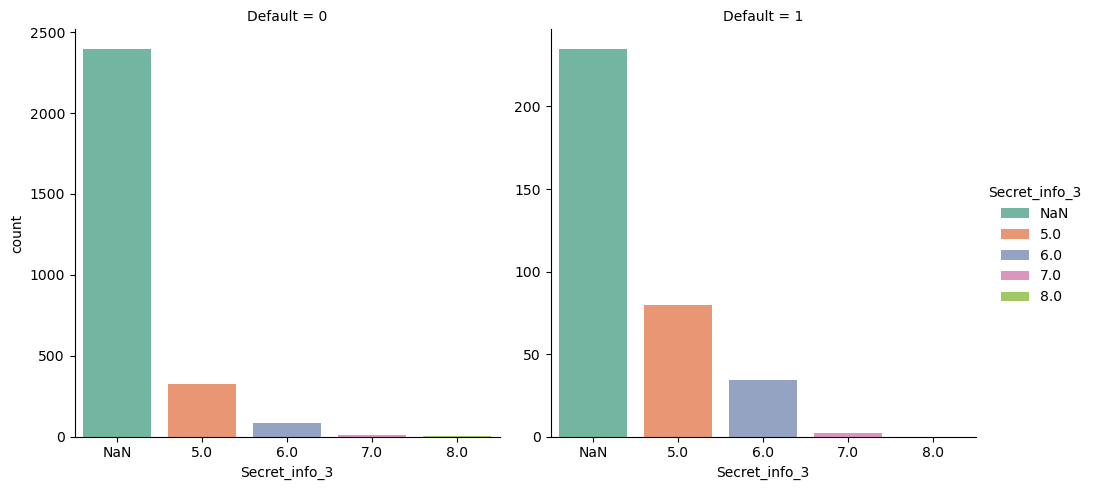

In [638]:
cols = ['Secret_info_1','Secret_info_2','Secret_info_3']
for col in cols:
    temp_df = df.copy()
    temp_df[col] = temp_df[col].fillna('NaN')
    fig = sns.catplot(x=col, kind='count', col='Default', data = temp_df, sharey=False, hue=col, palette='Set2')

Анализ всех трех признаков показывает зависимость их распределения от целевой переменной. `Secret_info_3`, хоть и ближе к вещественному типу данных, демонстрирует особое поведение пропущенных значений - они функционируют как отдельная категория. Поэтому для `Secret_info_1` и `Secret_info_3` оптимально ввести дополнительную категорию для пропусков, обозначив их нулями. В случае с `Secret_info_2` такой подход невозможен, так как ноль уже присутствует среди значений, поэтому здесь пропуски заполним строковым значением NaN.

In [639]:
df['Secret_info_1'] = df['Secret_info_1'].fillna(0).astype('category')
df['Secret_info_2'] = df['Secret_info_2'].fillna('NaN').astype('category')
df['Secret_info_3'] = df['Secret_info_3'].fillna('NaN').astype('category')

Колонка `Deal_id` не имеет особенной ценности для нас, так как id это уникальный номер, соответственно повторяться он не будет. Уберем эту колонку из датасета.

In [640]:
df = df.drop('Deal_id', axis=1)

Теперь выделим из `Deal_date` день, месяц и год и посмотрим как распределены таргеты относительно этих признаков. 

In [641]:
df['year'] = df['Deal_date'].astype('datetime64[ns]').dt.year
df['month'] = df['Deal_date'].astype('datetime64[ns]').dt.month
df['day'] = df['Deal_date'].astype('datetime64[ns]').dt.day

Год следует рассматривать как вещественный признак, а не категориальный, поскольку значения не повторяются, следовательно не могут быть категориями. Однако между годами может присутствовать тренд. У нас всего лишь два года в выборке (2015 и 2016), поэтому для поиска тренда лучше использовать дату в виде `ГГГГ-ММ`.

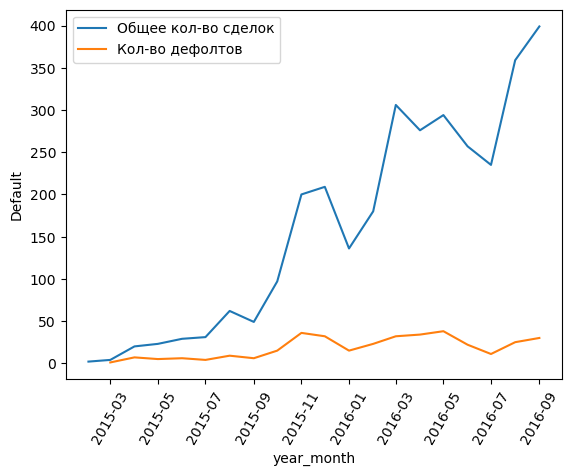

In [642]:
df['year_month'] = df.apply(lambda x: datetime(year = x['year'], month = x['month'], day=1), axis=1) 
df_temp1 = df.groupby('year_month')['Default'].count().reset_index()
df_temp2 = df[df['Default']==1].groupby('year_month')['Default'].count().reset_index()

sns.lineplot(x = 'year_month', y = 'Default', data = df_temp1, label='Общее кол-во сделок')
sns.lineplot(x = 'year_month', y = 'Default', data = df_temp2, label='Кол-во дефолтов')
plt.xticks(rotation=60)
plt.legend()
plt.show()

Видим что общее кол-во сделок имеет восходящий тренд, в то время как общее кол-во дефолтов имеет форму флета. Отсюда можно сделать вывод что, данные имеют временную структуру, потому что в прошлом отношение кол-ва дефолтов к общему кол-ву сделок было бОльшим. В таком случае можем оставить год как признак. 
С месяцем и с днем месяца (`month`, `day`) все сложнее. Помним что у нас в датасете всего 3168 объектов, месяцев 12, а дней в месяце до 31. Даже если в действительности в данных есть зависимость между этими признаками и таргетами, построив распределение таргетов по признакам есть риск увидеть около-случайную картину. Приведу утрированный пример - представьте что у нас в данных всего 40 объектов, а одним из признаков у нас является день месяца. Даже если таргет действительно имеет зависимость от дня месяца, построив распределение по дням мы высоковероятно увидем случайную картину, выводы по которой могут дать нам "ложный след". Данный случай, конечно, далек от приведенного примера и скорее всего 3168 объектов достаточно для того, чтобы понять есть ли взаимосвязь между признаками и таргетом, или нет. Однако, давайте перестрахуемся и дополнительно проведем статистический тест хи-квадрат, который покажет нам есть ли взаимосвязь между признаками и таргетом или нет. Сначала сделаем это для месяцев.

In [643]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['month'], df['Default'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
p_value


0.00012644519247791928

P_value равно 0.00012, это означает, что получить такой результат, при условии что признак и таргет независимы, равен 0.012%. Можно сделать вывод что месяц и таргет зависимы. В таком случае оставляем месяц в качестве признака. Сделаем то же самое с днями месяца. 

In [644]:
contingency_table = pd.crosstab(df['day'], df['Default'])  
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
p_value

0.4749777894317144

Видим что в данном случае вероятность получить такой результат, учитывая что дни месяца и таргеты независимы, составляет 47%. Это означает что в дальнейшем мы будем пробовать убирать данный признак из модели. Признак `year_month` можем удалить, так как он был вспомогательным. 

In [645]:
df = df.drop('year_month', axis=1)

Теперь рассмотрим признак `First_deal_date`. Сама по себе дата первой сделки не дает нам какого то преимущества, поэтому я попробую заменить ее на кол-во дней от первой сделки до текущей сделки. Моя гипотеза лежит в том, что это может выражать некоторую "опытность" заемщика, то есть чем больше это значение, тем лучше заемщик понимает механизмы займа и, предположительно, с большей вероятностью выполнит обязательства по возврату долга.

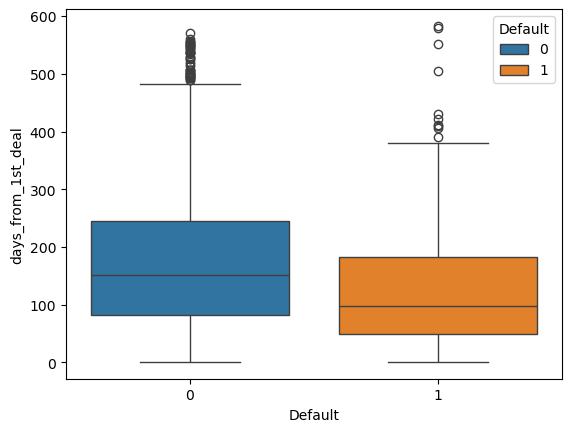

In [646]:
df['days_from_1st_deal'] = df['Deal_date'].astype('datetime64[ns]') - df['First_deal_date'].astype('datetime64[ns]')
df['days_from_1st_deal'] = df['days_from_1st_deal'].dt.days
sns.boxplot(data = df, y = df['days_from_1st_deal'], x = df['Default'].astype('category'), hue = df['Default'])
plt.show()

Видим картину, которая может подкрепить нашу уверенность в гипотезе "опытности". Клиенты по дефолтящим сделкам в среднем имеют меньшее кол-во дней, прошедшее от первой сделки. Оставляем данный признак, а признак `First_deal_date` удалим.

In [647]:
df = df.drop('First_deal_date', axis=1)

Следующим признаком рассмотрим `First_default_date`. Как и в случае с `First_deal_date`, сама по себе дата дефолта так же нам ничего не дает (помимо самого факта дефолта). На основе него стоит попробовать рассмотреть признак "количество, дней прошедших после дефолта". Объяснение следующее - недавний дефолт увеличивает риск повторного невыполнения обязательств, возможно отражая финансовую нестабильность или импульсивный характер заемщика.

<Axes: xlabel='Default', ylabel='days_after_default'>

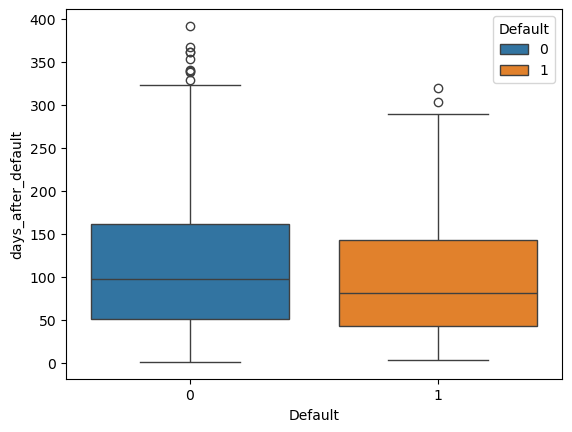

In [648]:
df['days_after_default'] = df['Deal_date'].astype('datetime64[ns]') - df['First_default_date'].astype('datetime64[ns]')
df['days_after_default'] = df['days_after_default'].dt.days
sns.boxplot(data=df[~(df['days_after_default'].isna())],  # рассматриваем только ту часть датасета где days_after_default is not None
            x = df[~(df['days_after_default'].isna())]['Default'].astype('category'),
            y = 'days_after_default', hue = df[~(df['days_after_default'].isna())]['Default'])

Мы видим что у клиентов дефолтящих сделок среднее время после первого дефолта слегка снижено, что согласуется с мыслью об "импульсивности" выдвинутой ранее. Данный признак оставляем, а`First_default_date` можно убрать.

In [649]:
df = df.drop(['First_default_date'], axis=1)
df['days_after_default'] = df['days_after_default'].fillna(0)

Теперь рассмотрим признаки `Region`, `institution` и `Gender`.
В признаке `Region` есть небольшое кол-во пропусков

In [650]:
df['Region'].value_counts(dropna=False)

Region
district_3    1204
district_6     478
district_2     448
district_4     364
district_1     240
district_0     213
district_5     160
district_7      54
NaN              7
Name: count, dtype: int64

Заполним эти пропуски самым популярным значением в признаке и взглянем на распределение таргетов.

In [651]:
df['Region'] = df['Region'].fillna(df['Region'].value_counts().index[0])

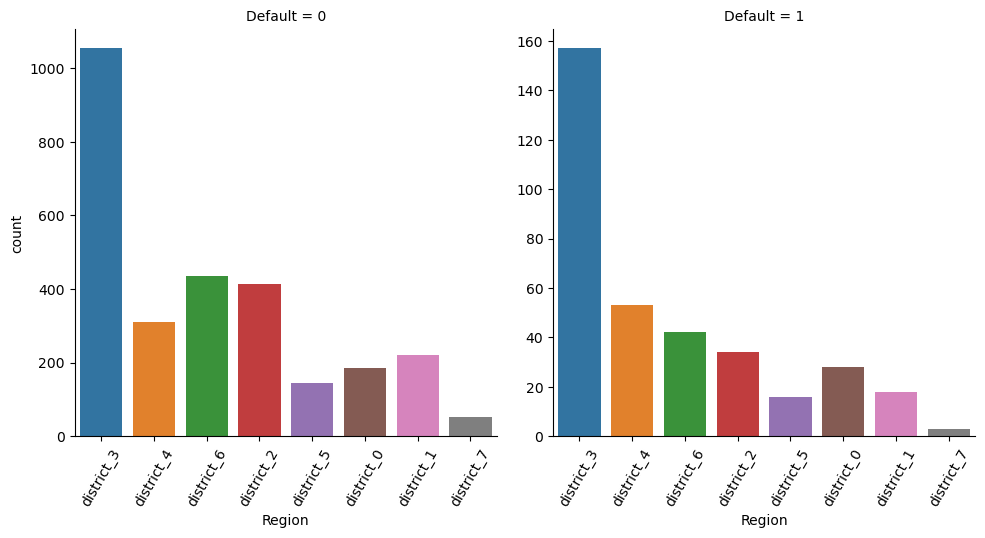

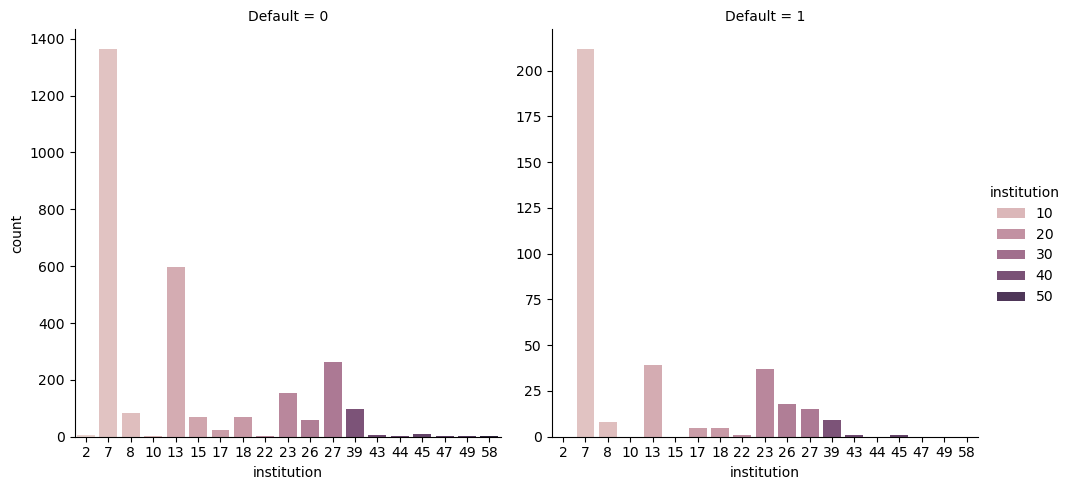

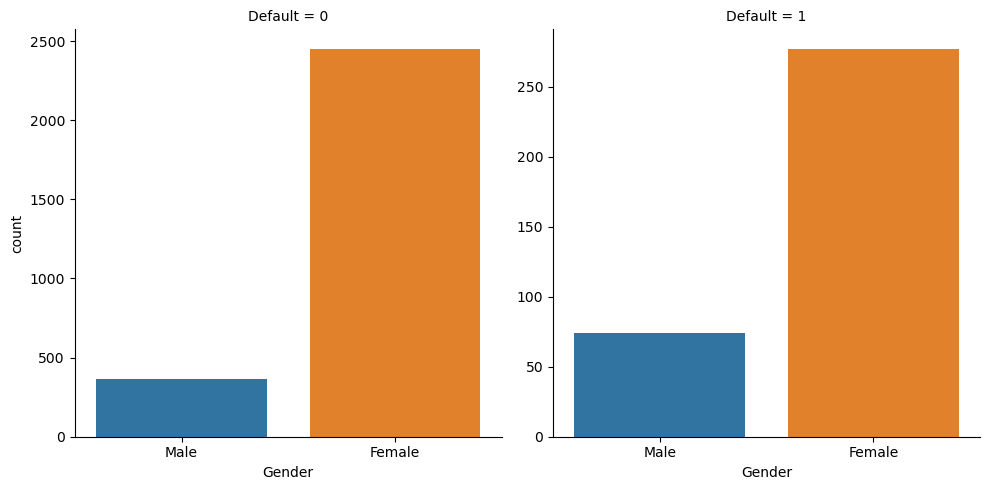

In [652]:
cols = ['Region','institution','Gender']
for col in cols:
    fig = sns.catplot(data = df, x = col, col = 'Default', kind='count', sharey=False, hue = col)
    if col == 'Region':
        fig.set_xticklabels(rotation=60)    

Видим что пропорции в признаках в разных классах таргета разные. Например среди дефолтящих сделок доля мужчин больше чем доля мужчин среди успешных сделок. Дополнительно обратимся к тесту хи-квадрат.

In [653]:
cols = ['Region','institution','Gender']
for col in cols:
    contingency_table = pd.crosstab(df[col], df['Default'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(p_value)

0.0018171703315723565
1.0387187120298823e-08
4.64163603300487e-05


Получаем очень маленькие цифры P_value, означающие, что получить такой результат, при условии что признаки не влияют на таргеты очень мал. Оставляем данные признаки.

Остались признаки, скрывающие хешированную детализацию сделки. Рассмотрим их подробнее.

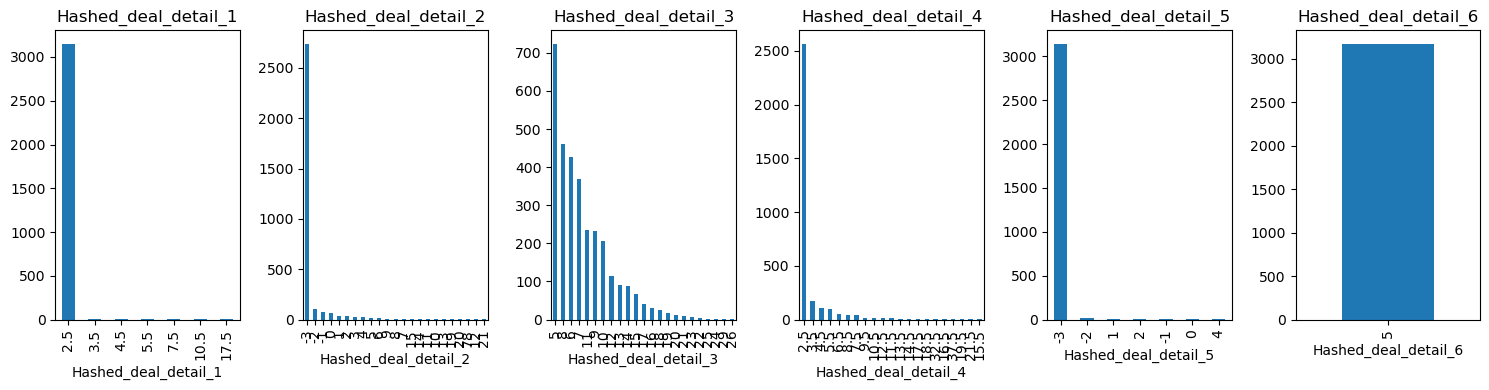

In [654]:
cols = ['Hashed_deal_detail_1','Hashed_deal_detail_2','Hashed_deal_detail_3','Hashed_deal_detail_4','Hashed_deal_detail_5','Hashed_deal_detail_6']
fig, axes = plt.subplots(1, len(cols), figsize=(15, 4))

for i, col in enumerate(cols):
    df[col].value_counts().plot(kind='bar', ax=axes[i], title=col)

plt.tight_layout()
plt.show()

Видим что признак `Hashed_deal_detail_6` константный, удалим его.

In [655]:
df = df.drop('Hashed_deal_detail_6', axis=1)

Сейчас у нас нет информации о том, являются ли данные признаки категориальными или вещественными. Попробуем провести тест на нормальность распределения, так как зачастую вещественные признаки распределены нормально.

In [656]:
cols = ['Hashed_deal_detail_1','Hashed_deal_detail_2','Hashed_deal_detail_3','Hashed_deal_detail_4','Hashed_deal_detail_5']
for col in cols:
    stat, p_value = scipy.stats.shapiro(df[col])
    print(p_value)

2.5592462108738673e-83
5.991203627299448e-78
5.047421419608962e-47
1.1785061846289095e-73
7.004228114929295e-83


`p_value` получились очень маленькие, что говорит о том что признаки не распределены нормально, и, скорее всего, врядли они являются вещественными.
Рассмотрим распределение таргетов по каждому из этих признаков.

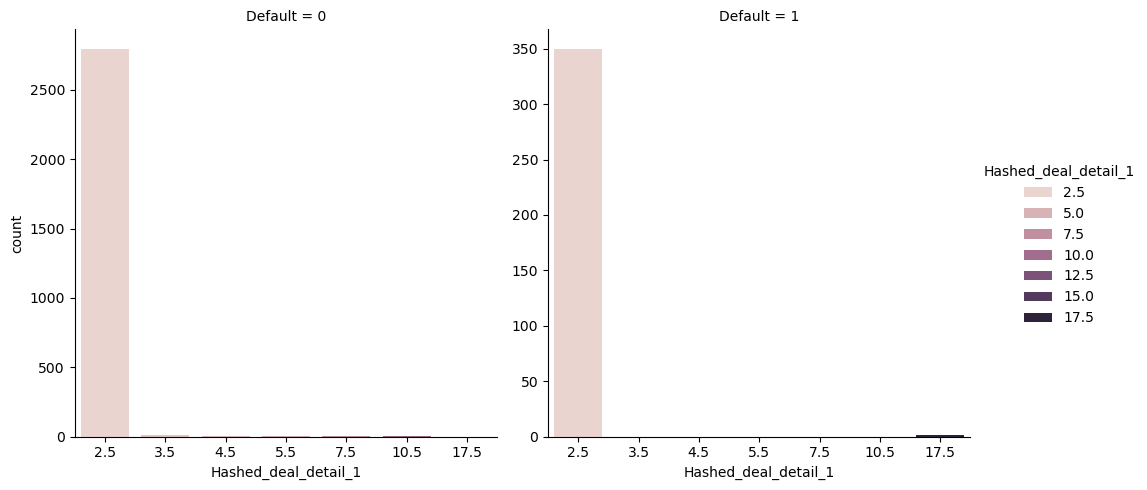

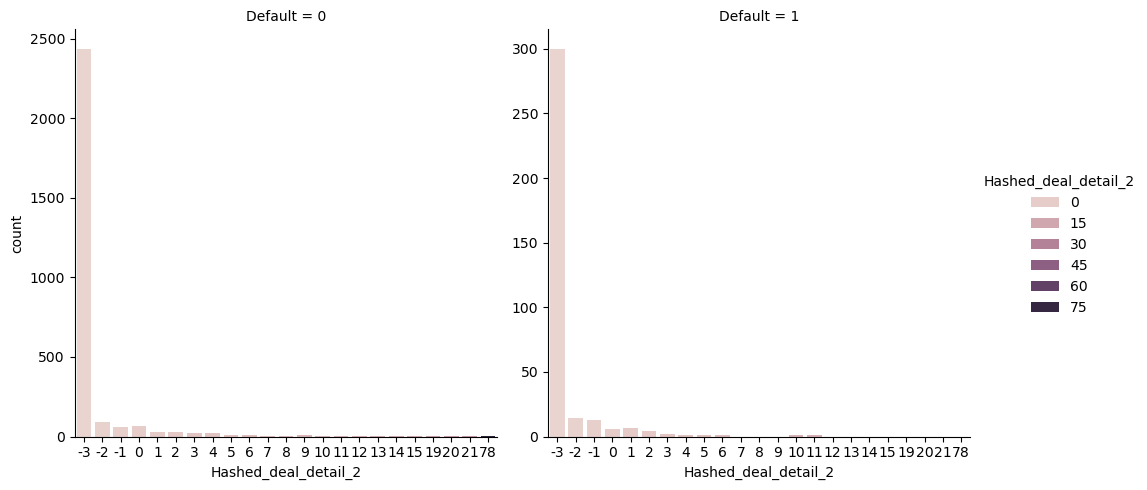

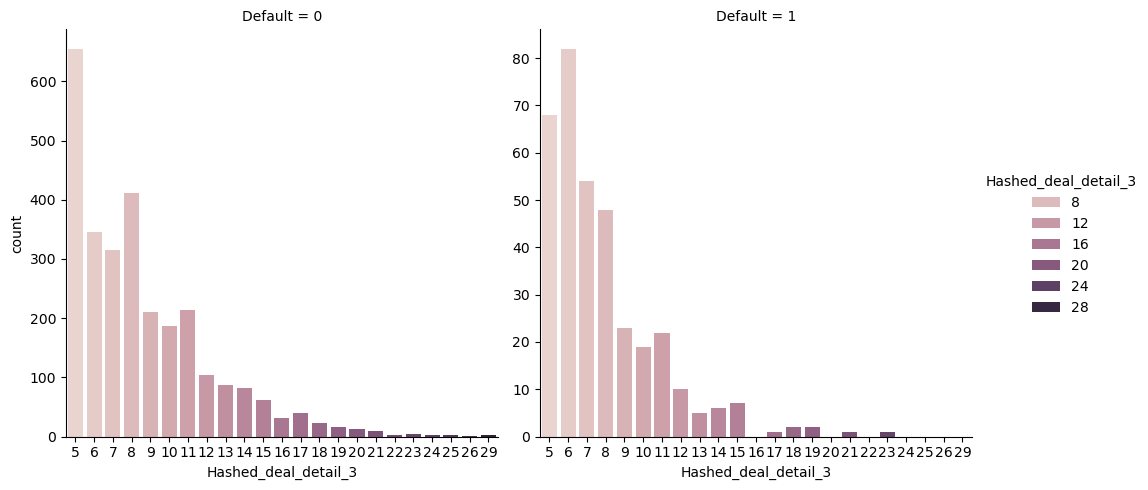

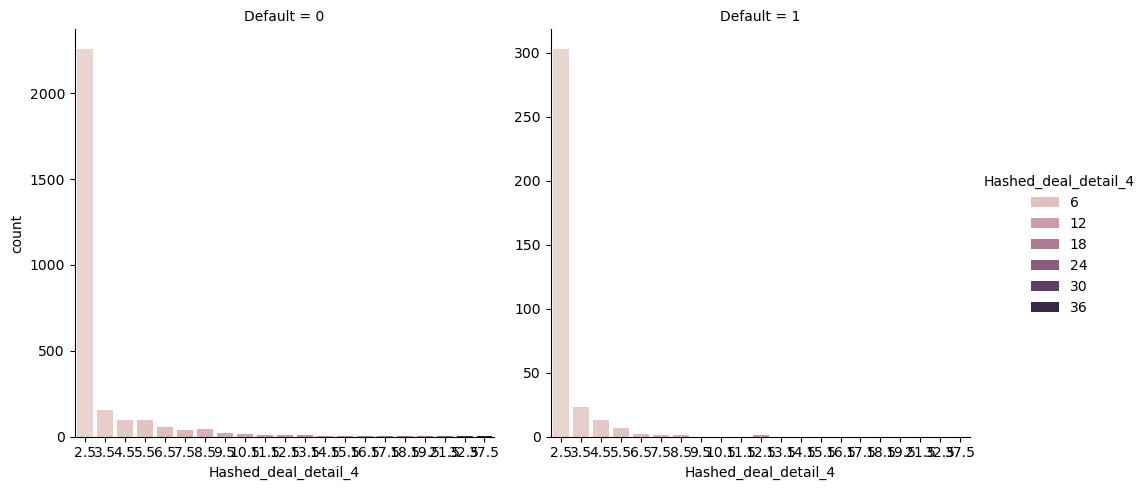

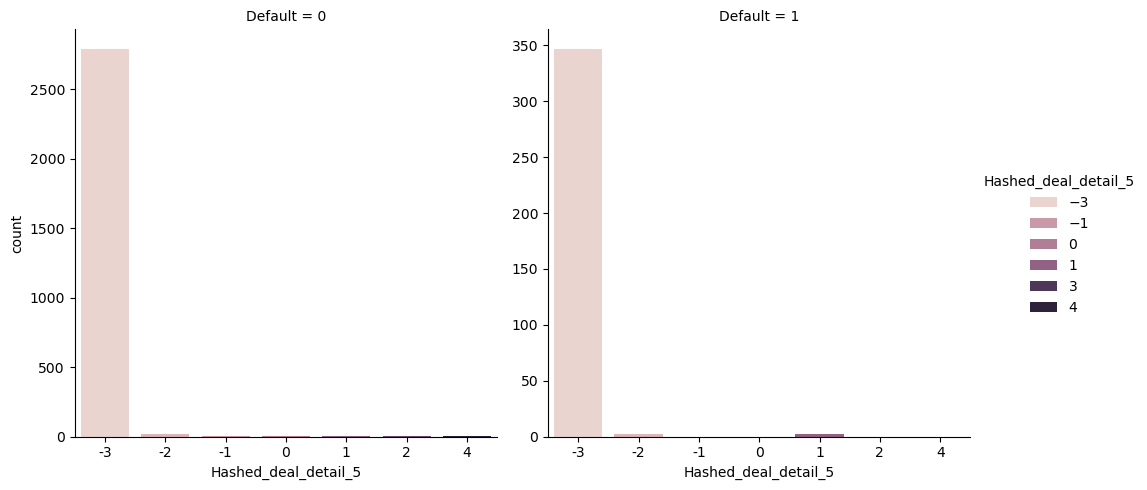

In [657]:
for col in cols:
    sns.catplot(data = df, x = col, col = 'Default', kind = 'count', sharey = False, hue = col)    

По первому и пятому признаку визуально очень сложно определить влияют ли они как то на таргет или нет (слева и справа картинка почти одинаковая, обычно если признак действительно оказывает влияние на таргет мы видим разные пропорции категорий внутри каждого класса (таргета)). Поэтому, как и ранее, проведем тест хи-квадрат.

In [658]:
for col in cols:
    contingency_table = pd.crosstab(df[col],df['Default'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f'Для признака {col} p_value =  {p_value}')

Для признака Hashed_deal_detail_1 p_value =  0.10427377757645624
Для признака Hashed_deal_detail_2 p_value =  0.8047778203399072
Для признака Hashed_deal_detail_3 p_value =  0.00027516422013255785
Для признака Hashed_deal_detail_4 p_value =  0.32334560390425054
Для признака Hashed_deal_detail_5 p_value =  0.11299105496131837


Видим что за исключением `Hashed_deal_detail_3` остальные признаки имеют `p_value` более 0.05, что означает что мы не можем опровергнуть гипотезу о том, что эти признаки действительно влияют на таргет. Поэтому эти признаки пойдут первыми на удаление когда мы будем эксперементировать с моделями.

Датасет имеет временную структуру, поэтому перед началом экспериментов с моделями сортируем наш датасет по колонке `Deal_date`, а затем удалим ее.

In [659]:
df['Deal_date'] = df['Deal_date'].astype('datetime64[ns]')
df = df.sort_values(by='Deal_date')
df = df.drop('Deal_date', axis=1)

### Эксперименты с моделями

Взглянем на датасет еще раз.

In [660]:
df.head()

,Secret_info_1,Secret_info_2,Secret_info_3,Successful_deals_count,Region,institution,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Default,year,month,day,days_from_1st_deal,days_after_default
1084,0.0,NaN,NaN,0.0,district_3,23,2.5,-3,5,2.5,-3,22.0,Male,0,2015,2,24,5,0.0
1047,0.0,NaN,NaN,0.0,district_4,7,2.5,-3,5,2.5,-3,30.0,Female,0,2015,2,28,14,0.0
1396,0.0,NaN,NaN,2.0,district_1,23,2.5,-2,5,2.5,-3,34.0,Female,0,2015,3,10,5,0.0
717,0.0,NaN,NaN,2.0,district_6,7,2.5,-3,5,2.5,-3,23.0,Female,1,2015,3,11,12,0.0
2877,0.0,NaN,NaN,0.0,district_3,23,2.5,-2,5,2.5,-3,32.0,Female,0,2015,3,17,28,0.0


Выделим категориальные и вещественные колонки.

In [661]:
cat_cols = ['Secret_info_1','Secret_info_2','Secret_info_3','Region','institution','Hashed_deal_detail_1',
           'Hashed_deal_detail_2','Hashed_deal_detail_3','Hashed_deal_detail_4','Hashed_deal_detail_5','Gender','month','day']
num_cols = ['Successful_deals_count','Age','year','days_from_1st_deal','days_after_default']

Не смотря на то, что в разделе EDA мы встретились с некоторыми вопросами, касающимися полезности признака `day` для данной задачи, пока будем относиться к нему как к категории.

Определим какие колонки мы будем препроцессить через `OHE`, а какие через `MTE`. Для `OHE` мы будем обрабатывать колонки, которые имеют в себе менее 6 уникальных значений.

In [662]:
for col in cat_cols:
    print(f'Уникальных значений для {col}: {len(df[col].unique())}')

Уникальных значений для Secret_info_1: 9
Уникальных значений для Secret_info_2: 7
Уникальных значений для Secret_info_3: 5
Уникальных значений для Region: 8
Уникальных значений для institution: 19
Уникальных значений для Hashed_deal_detail_1: 7
Уникальных значений для Hashed_deal_detail_2: 23
Уникальных значений для Hashed_deal_detail_3: 23
Уникальных значений для Hashed_deal_detail_4: 21
Уникальных значений для Hashed_deal_detail_5: 7
Уникальных значений для Gender: 2
Уникальных значений для month: 12
Уникальных значений для day: 31


In [663]:
cols_for_ohe = []
cols_for_mte = []
for col in cat_cols:
    if  len(df[col].unique()) < 6:
        cols_for_ohe.append(col)
    else:
        cols_for_mte.append(col)        

Определимся с метрикой оценивания качества модели. С одной стороны, у нас наблюдается дизбаланс классов. При дизбалансе классов часто используют метрику `average precision` или по другому "площадь под precision-recall кривой". Однако данный показатель строится вокруг положительного класса, то есть он подходит для тех задач, когда важно определять именно положительный класс. В нашем случае нам важно отличать сделку, которая имеет высокие шансы на дефолт, от сделки, которая должна быть успешной, то есть и тот и другой класс для нас имеюь значение. Поэтому, на мой взгляд, лучше для этих целей использовать `balanced accuracy`, потому что она удобна своей простой интерпретацией - это среднее арифметическое точности распознавания каждого класса. 

Для удобства разделим данные на основной датасет и таргет.

In [664]:
X = df.drop('Default', axis=1)
y = df['Default']

После `OHE` дополним `cat_cols` новыми колонками.

В разделе EDA мы выделили ряд признаков, которые вызывают вопросы относительно своей полезности. Выделим эти колонки в отдельный список.

In [665]:
cols_for_delete = ['day','Hashed_deal_detail_1','Hashed_deal_detail_2','Hashed_deal_detail_4','Hashed_deal_detail_5']

Создадим датафрейм куда будем записывать полученные результаты.

In [666]:
df_quality = pd.DataFrame()

### Log Reg

Начнем с логистической регрессии. Логистическая регрессия это одна из базовых моделей, которая, в отличие от деревьев решений или KNN, не лучшим образом может видеть нелинейные взаимосвязи в данных.

In [667]:
from sklearn.linear_model import LogisticRegression
from category_encoders import TargetEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
import warnings 
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = FitFailedWarning)
warnings.filterwarnings('ignore', category = UserWarning)



preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(), cols_for_ohe),
        ('cat', TargetEncoder(), cols_for_mte)
    ]
)

model = LogisticRegression(class_weight = 'balanced', random_state = 1)

lr_pipe = Pipeline([
    ('preprocess', preprocess),
    ('LR', model)    
])

grid = {
        'LR__C': [0.001, 0.01, 0.1, 1, 10],
    'LR__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

lr_search = GridSearchCV(lr_pipe,
                      param_grid=grid,
                      cv = TimeSeriesSplit(n_splits=4),
                      return_train_score=True,
                      scoring='balanced_accuracy')

lr_search.fit(X, y)
cv_results = pd.DataFrame(lr_search.cv_results_)[['mean_train_score','mean_test_score']]
best_idx = lr_search.best_index_
best_score = cv_results.iloc[best_idx].round(4)

print(f"Среднее качество на трейне : {best_score['mean_train_score']}")
print(f"Среднее качество на тесте : {best_score['mean_test_score']}")
print(f'Лучшие гиперпараметры: {lr_search.best_params_}')

df_quality.loc[f'Log_reg_все_колонки','mean_train_score'] = best_score['mean_train_score']
df_quality.loc[f'Log_reg_все_колонки','mean_test_score'] = best_score['mean_test_score']

Среднее качество на трейне : 0.687
Среднее качество на тесте : 0.667
Лучшие гиперпараметры: {'LR__C': 0.1, 'LR__solver': 'saga'}


Наш бейзлайн начинается с 0.687 и 0.667 для трейна и теста соответственно. 

Теперь давайте попробуем поочередно удалять колонки из `cols_for_delete` и снова обучать модель.

In [668]:
for col in cols_for_delete:
    cols_for_mte2 = ['Secret_info_1', 'Secret_info_2', 'Region', 'institution', 'Hashed_deal_detail_1', 'Hashed_deal_detail_2',
 'Hashed_deal_detail_3', 'Hashed_deal_detail_4', 'Hashed_deal_detail_5', 'month', 'day']
    X_deleted = X.copy()
    X_deleted = X_deleted.drop(col, axis=1)
    cols_for_mte2.remove(col)


    preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(), cols_for_ohe),
        ('cat', TargetEncoder(), cols_for_mte2)
    ]
    )
    
    model = LogisticRegression(class_weight = 'balanced', random_state = 1)
    
    
    lr_del_pipe = Pipeline([
        ('preprocess', preprocess),
        ('LR', model)    
    ])
    
    grid = {
            'LR__C': [0.001, 0.01, 0.1, 1, 10],
        'LR__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
    
    lr_del_search = GridSearchCV(lr_del_pipe,
                          param_grid=grid,
                          cv = TimeSeriesSplit(n_splits=4),
                          return_train_score=True,
                          scoring='balanced_accuracy')
    
    lr_del_search.fit(X_deleted, y)
    cv_results = pd.DataFrame(lr_del_search.cv_results_)[['mean_train_score','mean_test_score']]
    best_idx = lr_del_search.best_index_
    best_score = cv_results.iloc[best_idx].round(4)

    print(f'При удалении колонки "{col}"')
    print(f"Среднее качество на трейне : {best_score['mean_train_score']}")
    print(f"Среднее качество на тесте : {best_score['mean_test_score']}")
    print(f'Лучшие гиперпараметры: {lr_del_search.best_params_}')
    
    df_quality.loc[f'Log_reg_del_{col}','mean_train_score'] = best_score['mean_train_score']
    df_quality.loc[f'Log_reg_del_{col}','mean_test_score'] = best_score['mean_test_score']

При удалении колонки "day"
Среднее качество на трейне : 0.6786
Среднее качество на тесте : 0.6608
Лучшие гиперпараметры: {'LR__C': 0.01, 'LR__solver': 'sag'}
При удалении колонки "Hashed_deal_detail_1"
Среднее качество на трейне : 0.6788
Среднее качество на тесте : 0.6686
Лучшие гиперпараметры: {'LR__C': 0.01, 'LR__solver': 'liblinear'}
При удалении колонки "Hashed_deal_detail_2"
Среднее качество на трейне : 0.6863
Среднее качество на тесте : 0.6644
Лучшие гиперпараметры: {'LR__C': 0.1, 'LR__solver': 'saga'}
При удалении колонки "Hashed_deal_detail_4"
Среднее качество на трейне : 0.6855
Среднее качество на тесте : 0.6632
Лучшие гиперпараметры: {'LR__C': 0.1, 'LR__solver': 'saga'}
При удалении колонки "Hashed_deal_detail_5"
Среднее качество на трейне : 0.6878
Среднее качество на тесте : 0.6676
Лучшие гиперпараметры: {'LR__C': 0.1, 'LR__solver': 'saga'}


Из всех вариантов удалений признаков только при удалении `Hashed_deal_detail_1` качество на тесте выросло очень не значительно (0.0016), в остальных случаях качество на тесте либо не изменилось либо упало. При этом при удалении `Hashed_deal_detail_5` качество на трейне так же не значительно улучшилось по сравнению с бейзлайном (на 0.0008).

### SVM

Метод опорных векторов способен совмещать в себе возможность видеть тренды (как в линейной регрессии) и возможность видеть нелинейные взаимосвязи (в случае если мы в качестве гиперпараметра используем не линейное ядро). 

In [669]:
from sklearn.svm import SVC

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(), cols_for_ohe),
        ('cat', TargetEncoder(), cols_for_mte)
    ]
)

model = SVC(random_state = 1, class_weight='balanced')

svc_pipe = Pipeline([
    ('preprocess', preprocess),
    ('SVC', model)
])

grid = {
    'SVC__C': [0.1, 1, 10, 100],
    'SVC__kernel': ['linear','rbf', 'poly', 'sigmoid'],
    'SVC__max_iter': [100,1000,10000],
    'SVC__gamma': ['scale', 'auto',0.0001, 0.001, 0.01, 0.1, 1]
    
}

svc_search = GridSearchCV(svc_pipe,
                      scoring = 'balanced_accuracy',
                      param_grid=grid, 
                      cv = TimeSeriesSplit(n_splits=4),
                      return_train_score=True)

svc_search.fit(X,y)
cv_results = pd.DataFrame(svc_search.cv_results_)[['mean_train_score', 'mean_test_score']]
best_idx = svc_search.best_index_
best_score = cv_results.iloc[best_idx].round(4)

print(f"Среднее качество на трейне : {best_score['mean_train_score']}")
print(f"Среднее качество на тесте : {best_score['mean_test_score']}")
print(f'Лучшие гиперпараметры: {svc_search.best_params_}')

Среднее качество на трейне : 0.681
Среднее качество на тесте : 0.6695
Лучшие гиперпараметры: {'SVC__C': 0.1, 'SVC__gamma': 'scale', 'SVC__kernel': 'linear', 'SVC__max_iter': 10000}


Результат на тесте лучше чем у логистической регрессии. При этом при валидации гиперпараметров `gamma` встала в 0.0001, это говорит о том что, модель очень слабо использует возможности нелинейного ядра. Поэтому давайте сделаем еще один эксперимент с той же моделью, без ограничения в виде max_iter, для того чтобы понять, а есть ли смысл в нелинейных ядрах для данной задачи?

In [670]:
import time
start = time.time()
from sklearn.svm import SVC

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(), cols_for_ohe),
        ('cat', TargetEncoder(), cols_for_mte)
    ]
)

model = SVC(random_state = 1, class_weight='balanced')

svc_del_pipe = Pipeline([
    ('preprocess', preprocess),
    ('SVC', model)
])

grid = {
    'SVC__C': [0.1, 1, 10, 100],
    'SVC__kernel': ['linear','rbf', 'poly', 'sigmoid']
}

svc_del_search = GridSearchCV(svc_del_pipe,
                      scoring = 'balanced_accuracy',
                      param_grid=grid, 
                      cv = TimeSeriesSplit(n_splits=4),
                      return_train_score=True)

svc_del_search.fit(X,y)
cv_results = pd.DataFrame(svc_del_search.cv_results_)[['mean_train_score', 'mean_test_score']]
best_idx = svc_del_search.best_index_
best_score = cv_results.iloc[best_idx].round(4)

print(f"Среднее качество на трейне : {best_score['mean_train_score']}")
print(f"Среднее качество на тесте : {best_score['mean_test_score']}")
print(f'Лучшие гиперпараметры: {svc_del_search.best_params_}')

Среднее качество на трейне : 0.6798
Среднее качество на тесте : 0.6686
Лучшие гиперпараметры: {'SVC__C': 0.1, 'SVC__kernel': 'linear'}


В модели без ограничений при валидации гиперпараметров лучшее ядро действительно оказалось линейным. Это говорит о том, что данные в датасете могут быть линейно разделимы. Учитывая это, давайте прямо воспользуемся LinearSVC чтобы более тонко настроить SVC с линейным ядром.

In [671]:
import time
start = time.time()
from sklearn.svm import LinearSVC

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(), cols_for_ohe),
        ('cat', TargetEncoder(), cols_for_mte)
    ]
)

model = LinearSVC(random_state = 1, class_weight='balanced')

linscv_pipe = Pipeline([
    ('preprocess', preprocess),
    ('SVC', model)
])

grid = {
    'SVC__C': [0.1, 1, 10, 100],
    'SVC__loss': ['hinge', 'squared_hinge'],
    'SVC__penalty': ['l1', 'l2'],
    'SVC__tol': [0.8, 0.5,0.1,1e-2,1e-3, 1e-4, 1e-5]
}

lincvs_search = GridSearchCV(linscv_pipe,
                      scoring = 'balanced_accuracy',
                      param_grid=grid, 
                      cv = TimeSeriesSplit(n_splits=4),
                      return_train_score=True)

lincvs_search.fit(X,y)
cv_results = pd.DataFrame(lincvs_search.cv_results_)[['mean_train_score', 'mean_test_score']]
best_idx = lincvs_search.best_index_
best_score = cv_results.iloc[best_idx].round(4)

print(f"Среднее качество на трейне : {best_score['mean_train_score']}")
print(f"Среднее качество на тесте : {best_score['mean_test_score']}")
print(f'Лучшие гиперпараметры: {lincvs_search.best_params_}')

df_quality.loc[f'LinearSVC_все_колонки','mean_train_score'] = best_score['mean_train_score']
df_quality.loc[f'LinearSVC_все_колонки','mean_test_score'] = best_score['mean_test_score']

Среднее качество на трейне : 0.6856
Среднее качество на тесте : 0.6696
Лучшие гиперпараметры: {'SVC__C': 0.1, 'SVC__loss': 'squared_hinge', 'SVC__penalty': 'l1', 'SVC__tol': 0.8}


Видим что валидирование гиперпараметров в `LinearSVC` дало очень незначительное преимущество (+0,0001) на тесте по сравнению последней лучшей моделью, однако на трейне все еще лучше всех себя показывает логистическая регрессия (0.6878).
Теперь попробуем вариант с удалением признаков.

In [672]:
for col in cols_for_delete:
    cols_for_mte2 = ['Secret_info_1', 'Secret_info_2', 'Region', 'institution', 'Hashed_deal_detail_1', 'Hashed_deal_detail_2',
 'Hashed_deal_detail_3', 'Hashed_deal_detail_4', 'Hashed_deal_detail_5', 'month', 'day']
    X_deleted = X.copy()
    X_deleted = X_deleted.drop(col, axis=1)
    cols_for_mte2.remove(col)


    preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(), cols_for_ohe),
        ('cat', TargetEncoder(), cols_for_mte2)
    ]
    )
    
    model = LinearSVC(random_state = 1, class_weight='balanced')
    
    lincvs_del_pipe = Pipeline([
        ('preprocess', preprocess),
        ('SVC', model)
    ])
    
    grid = {
        'SVC__C': [0.1, 1, 10, 100],
        'SVC__loss': ['hinge', 'squared_hinge'],
        'SVC__penalty': ['l1', 'l2'],
        'SVC__tol': [0.8, 0.5,0.1,1e-2,1e-3, 1e-4, 1e-5]
    }
    
    lincvs_del_search = GridSearchCV(lincvs_del_pipe,
                          scoring = 'balanced_accuracy',
                          param_grid=grid, 
                          cv = TimeSeriesSplit(n_splits=4),
                          return_train_score=True)
    
    lincvs_del_search.fit(X,y)
    cv_results = pd.DataFrame(lincvs_del_search.cv_results_)[['mean_train_score', 'mean_test_score']]
    best_idx = lincvs_del_search.best_index_
    best_score = cv_results.iloc[best_idx].round(4)

    print(f'При удалении колонки "{col}"')
    print(f"Среднее качество на трейне : {best_score['mean_train_score']}")
    print(f"Среднее качество на тесте : {best_score['mean_test_score']}")
    print(f'Лучшие гиперпараметры: {lincvs_del_search.best_params_}')
    
    df_quality.loc[f'LinearSVC_del_{col}','mean_train_score'] = best_score['mean_train_score']
    df_quality.loc[f'LinearSVC_del_{col}','mean_test_score'] = best_score['mean_test_score']

При удалении колонки "day"
Среднее качество на трейне : 0.6806
Среднее качество на тесте : 0.668
Лучшие гиперпараметры: {'SVC__C': 0.1, 'SVC__loss': 'hinge', 'SVC__penalty': 'l2', 'SVC__tol': 0.5}
При удалении колонки "Hashed_deal_detail_1"
Среднее качество на трейне : 0.6843
Среднее качество на тесте : 0.6662
Лучшие гиперпараметры: {'SVC__C': 0.1, 'SVC__loss': 'squared_hinge', 'SVC__penalty': 'l1', 'SVC__tol': 0.8}
При удалении колонки "Hashed_deal_detail_2"
Среднее качество на трейне : 0.6864
Среднее качество на тесте : 0.6661
Лучшие гиперпараметры: {'SVC__C': 0.1, 'SVC__loss': 'squared_hinge', 'SVC__penalty': 'l1', 'SVC__tol': 0.8}
При удалении колонки "Hashed_deal_detail_4"
Среднее качество на трейне : 0.685
Среднее качество на тесте : 0.6647
Лучшие гиперпараметры: {'SVC__C': 1, 'SVC__loss': 'squared_hinge', 'SVC__penalty': 'l1', 'SVC__tol': 0.5}
При удалении колонки "Hashed_deal_detail_5"
Среднее качество на трейне : 0.6832
Среднее качество на тесте : 0.6693
Лучшие гиперпараметры:

Ни один из вариантов не сместил лидера.

### KNN

In [673]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(), cols_for_ohe),
        ('cat', TargetEncoder(), cols_for_mte)
    ]
)
knn_pipe = Pipeline([
    ('preprocess', preprocess),
    ('KNN', KNeighborsClassifier(n_jobs = -1))
])

def gaussian_kernel(distances, h=1):
        return np.exp(- distances**2 / h**2) 

grid = {
    'KNN__n_neighbors': [1,3,5,10,20],
    'KNN__weights': ['uniform','distance',gaussian_kernel],
    'KNN__p': [1,2,3],
    'KNN__algorithm':['auto','ball_tree','kd_tree','brute']
}

knn_search = GridSearchCV(knn_pipe,
                      scoring = 'balanced_accuracy',
                      param_grid = grid,
                      cv = TimeSeriesSplit(n_splits=4),
                      return_train_score=True)

knn_search.fit(X,y)
cv_results = pd.DataFrame(knn_search.cv_results_)[['mean_train_score', 'mean_test_score']]
best_idx = knn_search.best_index_
best_score = cv_results.iloc[best_idx].round(4)

print(f"Среднее качество на трейне : {best_score['mean_train_score']}")
print(f"Среднее качество на тесте : {best_score['mean_test_score']}")
print(f'Лучшие гиперпараметры: {knn_search.best_params_}')

df_quality.loc[f'KNN_все_колонки','mean_train_score'] = best_score['mean_train_score']
df_quality.loc[f'KNN_все_колонки','mean_test_score'] = best_score['mean_test_score']

Среднее качество на трейне : 0.6789
Среднее качество на тесте : 0.5219
Лучшие гиперпараметры: {'KNN__algorithm': 'auto', 'KNN__n_neighbors': 3, 'KNN__p': 2, 'KNN__weights': 'uniform'}


Модель сильно переобучилась, к тому же были подобраны самые "простые" гиперпараметры (при k=1 модель принимает решение на основе только одного ближайшего соседа), это может говорить о том, что объекты, даже если у них одинаковое признаковое описание, склонны иметь различные таргеты. Поэтому KNN в данной задаче можно не развивать.

### TREE

In [674]:
from sklearn.tree import DecisionTreeClassifier

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(), cols_for_ohe),
        ('cat', TargetEncoder(), cols_for_mte)
    ]
)

tree_pipe = Pipeline([
    ('preprocess', preprocess),
    ('Tree', DecisionTreeClassifier(random_state=1, class_weight = 'balanced'))
])

grid =  {
    'Tree__max_depth': [None, 5, 10, 15, 20],
    'Tree__min_samples_split': [2, 5, 10],
    'Tree__min_samples_leaf': [1, 2, 4],
    'Tree__max_features': ['sqrt', 'log2', None],
    'Tree__criterion': ['gini', 'entropy'],
    'Tree__min_impurity_decrease': [0.01,0.1]
}

tree_search = GridSearchCV(tree_pipe,
                      scoring = 'balanced_accuracy',
                      param_grid = grid,
                      cv = TimeSeriesSplit(n_splits=4),
                      return_train_score=True)

tree_search.fit(X,y)
cv_results = pd.DataFrame(tree_search.cv_results_)[['mean_train_score', 'mean_test_score']]
best_idx = tree_search.best_index_
best_score = cv_results.iloc[best_idx].round(4)

print(f"Среднее качество на трейне : {best_score['mean_train_score']}")
print(f"Среднее качество на тесте : {best_score['mean_test_score']}")
print(f'Лучшие гиперпараметры: {tree_search.best_params_}')

df_quality.loc[f'Tree_все_колонки','mean_train_score'] = best_score['mean_train_score']
df_quality.loc[f'Tree_все_колонки','mean_test_score'] = best_score['mean_test_score']

Среднее качество на трейне : 0.6792
Среднее качество на тесте : 0.6523
Лучшие гиперпараметры: {'Tree__criterion': 'gini', 'Tree__max_depth': None, 'Tree__max_features': None, 'Tree__min_impurity_decrease': 0.01, 'Tree__min_samples_leaf': 1, 'Tree__min_samples_split': 2}


Вариант с удалением признаков.

In [675]:
for col in cols_for_delete:
    cols_for_mte2 = ['Secret_info_1', 'Secret_info_2', 'Region', 'institution', 'Hashed_deal_detail_1', 'Hashed_deal_detail_2',
 'Hashed_deal_detail_3', 'Hashed_deal_detail_4', 'Hashed_deal_detail_5', 'month', 'day']
    X_deleted = X.copy()
    X_deleted = X_deleted.drop(col, axis=1)
    cols_for_mte2.remove(col)


    preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(), cols_for_ohe),
        ('cat', TargetEncoder(), cols_for_mte2)
    ]
    )
    
    tree_del_pipe = Pipeline([
        ('preprocess', preprocess),
        ('Tree', DecisionTreeClassifier(random_state=1, class_weight = 'balanced'))
    ])
    
    grid =  {
        'Tree__max_depth': [None, 5, 10, 15, 20],
        'Tree__min_samples_split': [2, 5, 10],
        'Tree__min_samples_leaf': [1, 2, 4],
        'Tree__max_features': ['sqrt', 'log2', None],
        'Tree__criterion': ['gini', 'entropy'],
        'Tree__min_impurity_decrease': [0.01,0.1]
    }
    
    tree_del_search = GridSearchCV(tree_del_pipe,
                          scoring = 'balanced_accuracy',
                          param_grid = grid,
                          cv = TimeSeriesSplit(n_splits=4),
                          return_train_score=True)
    
    tree_del_search.fit(X,y)
    cv_results = pd.DataFrame(tree_del_search.cv_results_)[['mean_train_score', 'mean_test_score']]
    best_idx = tree_del_search.best_index_
    best_score = cv_results.iloc[best_idx].round(4)

    print(f'При удалении колонки "{col}"')
    print(f"Среднее качество на трейне : {best_score['mean_train_score']}")
    print(f"Среднее качество на тесте : {best_score['mean_test_score']}")
    print(f'Лучшие гиперпараметры: {tree_del_search.best_params_}')
    
    df_quality.loc[f'Tree_del_{col}','mean_train_score'] = best_score['mean_train_score']
    df_quality.loc[f'Tree_del_{col}','mean_test_score'] = best_score['mean_test_score']

При удалении колонки "day"
Среднее качество на трейне : 0.6792
Среднее качество на тесте : 0.6523
Лучшие гиперпараметры: {'Tree__criterion': 'gini', 'Tree__max_depth': None, 'Tree__max_features': None, 'Tree__min_impurity_decrease': 0.01, 'Tree__min_samples_leaf': 1, 'Tree__min_samples_split': 2}
При удалении колонки "Hashed_deal_detail_1"
Среднее качество на трейне : 0.6792
Среднее качество на тесте : 0.6523
Лучшие гиперпараметры: {'Tree__criterion': 'gini', 'Tree__max_depth': None, 'Tree__max_features': None, 'Tree__min_impurity_decrease': 0.01, 'Tree__min_samples_leaf': 1, 'Tree__min_samples_split': 2}
При удалении колонки "Hashed_deal_detail_2"
Среднее качество на трейне : 0.6792
Среднее качество на тесте : 0.6523
Лучшие гиперпараметры: {'Tree__criterion': 'gini', 'Tree__max_depth': None, 'Tree__max_features': None, 'Tree__min_impurity_decrease': 0.01, 'Tree__min_samples_leaf': 1, 'Tree__min_samples_split': 2}
При удалении колонки "Hashed_deal_detail_4"
Среднее качество на трейне :

Дерево показывает себя как второй (после KNN) худший алгоритм, что заставляет задуматься о том, что скорее всего в данной задаче линейная разделимость признаков играет ключевую роль и превалирует над нелинейными зависимостями.

### Catboost

In [676]:
from catboost import CatBoostClassifier

'''
Catboost не может работать с категориями если они представляют из себя числа с плавающей точкой, поэтому переведем все колонки в тип str
'''

for col in cat_cols:
    X[col] = X[col].astype(str)


preprocess = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(), cols_for_ohe),
        ('cat','passthrough', cols_for_mte2) # пропускаю признаки без изменений потому что Catboost самостоятельно работает с категориальными признаками
    ] , remainder='passthrough',
    verbose_feature_names_out = True
)
    


'''
Используя Pipeline с catboost случается так, что проходя через пайплайн названия признаков преобразуются и cat_boost не может их затем найти,
чтобы этого избежать можно вместо названий столбцов передать их индексы.
'''

X_processed = preprocess.fit_transform(X)
cat_indices = []
for idx, name in enumerate(preprocess.get_feature_names_out()):
    if 'cat__' in name:
        cat_indices.append(idx)


cat_pipe = Pipeline([
    ('preprocess', preprocess),
    ('Cat', CatBoostClassifier(random_seed=1,
                               auto_class_weights = 'Balanced',
                               has_time = True,
                              cat_features=cat_indices,
                              thread_count = 4,
                              logging_level='Silent'))
]) 


grid = {
    'Cat__iterations': [100,300,500,1000],
    'Cat__depth': [1, 2, 5],
    'Cat__l2_leaf_reg': [3, 5, 7, 9]
}

cat_search = GridSearchCV(cat_pipe,
                      scoring = 'balanced_accuracy',
                      param_grid = grid,
                      cv = TimeSeriesSplit(n_splits=4),
                      return_train_score=True)

cat_search.fit(X,y)
cv_results = pd.DataFrame(cat_search.cv_results_)[['mean_train_score', 'mean_test_score']]
best_idx = cat_search.best_index_
best_score = cv_results.iloc[best_idx].round(4)

print(f"Среднее качество на трейне : {best_score['mean_train_score']}")
print(f"Среднее качество на тесте : {best_score['mean_test_score']}")
print(f'Лучшие гиперпараметры: {cat_search.best_params_}')

df_quality.loc[f'Catboost_все_колонки','mean_train_score'] = best_score['mean_train_score']
df_quality.loc[f'Catboost_все_колонки','mean_test_score'] = best_score['mean_test_score']

Среднее качество на трейне : 0.7304
Среднее качество на тесте : 0.6669
Лучшие гиперпараметры: {'Cat__depth': 5, 'Cat__iterations': 100, 'Cat__l2_leaf_reg': 3}


Вариант с удалением признаков

In [677]:
for col in cols_for_delete:
    cols_for_mte2 = ['Secret_info_1', 'Secret_info_2', 'Region', 'institution', 'Hashed_deal_detail_1', 'Hashed_deal_detail_2',
 'Hashed_deal_detail_3', 'Hashed_deal_detail_4', 'Hashed_deal_detail_5', 'month', 'day']
    X_deleted = X.copy()
    X_deleted = X_deleted.drop(col, axis=1)
    cols_for_mte2.remove(col)

    for col in cat_cols:
        X[col] = X[col].astype(str)
    
    
    preprocess = ColumnTransformer(
        transformers = [
            ('num', StandardScaler(), num_cols),
            ('ohe', OneHotEncoder(), cols_for_ohe),
            ('cat','passthrough', cols_for_mte2) # пропускаю признаки без изменений потому что Catboost самостоятельно работает с категориальными признаками
        ] , remainder='passthrough',
        verbose_feature_names_out = True
    )
    
    X_processed = preprocess.fit_transform(X)
    cat_indices = []
    for idx, name in enumerate(preprocess.get_feature_names_out()):
        if 'cat__' in name:
            cat_indices.append(idx)
    
    
    cat_del_pipe = Pipeline([
        ('preprocess', preprocess),
        ('Cat', CatBoostClassifier(random_seed=1,
                                   auto_class_weights = 'Balanced',
                                   has_time = True,
                                  cat_features=cat_indices,
                                  thread_count = 4,
                                  logging_level='Silent'))
    ]) 
    
    
    grid = {
        'Cat__iterations': [100,300,500,1000],
        'Cat__depth': [1, 2, 5],
        'Cat__l2_leaf_reg': [3, 5, 7, 9]
    }
    
    cat_del_search = GridSearchCV(cat_del_pipe,
                          scoring = 'balanced_accuracy',
                          param_grid = grid,
                          cv = TimeSeriesSplit(n_splits=4),
                          return_train_score=True)
    
    cat_del_search.fit(X,y)
    cv_results = pd.DataFrame(cat_del_search.cv_results_)[['mean_train_score', 'mean_test_score']]
    best_idx = cat_del_search.best_index_
    best_score = cv_results.iloc[best_idx].round(4)

    print(f'При удалении колонки "{col}"')
    print(f"Среднее качество на трейне : {best_score['mean_train_score']}")
    print(f"Среднее качество на тесте : {best_score['mean_test_score']}")
    print(f'Лучшие гиперпараметры: {cat_del_search.best_params_}')
    
    df_quality.loc[f'Catboost_del_{col}','mean_train_score'] = best_score['mean_train_score']
    df_quality.loc[f'Catboost_del_{col}','mean_test_score'] = best_score['mean_test_score']

При удалении колонки "day"
Среднее качество на трейне : 0.7166
Среднее качество на тесте : 0.6631
Лучшие гиперпараметры: {'Cat__depth': 1, 'Cat__iterations': 300, 'Cat__l2_leaf_reg': 9}
При удалении колонки "day"
Среднее качество на трейне : 0.7262
Среднее качество на тесте : 0.6659
Лучшие гиперпараметры: {'Cat__depth': 1, 'Cat__iterations': 500, 'Cat__l2_leaf_reg': 9}
При удалении колонки "day"
Среднее качество на трейне : 0.7267
Среднее качество на тесте : 0.6649
Лучшие гиперпараметры: {'Cat__depth': 1, 'Cat__iterations': 500, 'Cat__l2_leaf_reg': 3}
При удалении колонки "day"
Среднее качество на трейне : 0.7274
Среднее качество на тесте : 0.6688
Лучшие гиперпараметры: {'Cat__depth': 1, 'Cat__iterations': 500, 'Cat__l2_leaf_reg': 7}
При удалении колонки "day"
Среднее качество на трейне : 0.7304
Среднее качество на тесте : 0.6669
Лучшие гиперпараметры: {'Cat__depth': 5, 'Cat__iterations': 100, 'Cat__l2_leaf_reg': 3}


`Catboost` лучше всех себя показывает на трейне (+0,042 от ближайшего лучшего алгоритма).

Взглянем на итоговые результаты, отсортированные по mean_test_score в убывающем порядке.

In [678]:
df_quality['rank'] = df_quality['mean_test_score'].rank(method='dense', ascending=False).astype(int)
df_quality.sort_values(by='mean_test_score', ascending=False)

,mean_train_score,mean_test_score,rank
LinearSVC_все_колонки,0.6856,0.6696,1
LinearSVC_del_Hashed_deal_detail_5,0.6832,0.6693,2
Log_reg_del_Hashed_deal_detail_1,0.6788,0.6686,3
LinearSVC_del_day,0.6806,0.6680,4
Log_reg_del_Hashed_deal_detail_5,0.6878,0.6676,5
Log_reg_все_колонки,0.6870,0.6670,6
Catboost_все_колонки,0.7304,0.6669,7
Catboost_del_day,0.7304,0.6669,7
LinearSVC_del_Hashed_deal_detail_1,0.6843,0.6662,8
LinearSVC_del_Hashed_deal_detail_2,0.6864,0.6661,9


Формально победил алгоритм `LinearSVC` с вариантом, в котором ни одна колонка не была удалена. Самые лучшие алгоритмы представляют из себя линейные модели. Самые худшие модели это как раз модели, которые лучше всего умеют работать с нелинейными взаимосвязями (`KNN`, деревья). Это говорит нам о том, что в данной задаче линейное разделение играет гораздо бОльшую роль над нелинейными взаимосвязями.
`Catboost` показал себя так же неплохо, отставание от лидера на тесте всего 0.0027, при этом имеет самую высокую оценку на трейне.
При прочих равных можно остановиться на простой линейной модели.
Сохраним лидирующую модель.

In [679]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(), cols_for_ohe),
        ('cat', TargetEncoder(), cols_for_mte)
    ]
)

base_model = LinearSVC(random_state = 1,
                  class_weight='balanced',
                  C=0.1, loss='squared_hinge',
                  penalty='l1',tol=0.8)

model = CalibratedClassifierCV(base_model)

linscv_pipe = Pipeline([
    ('preprocess', preprocess),
    ('SVC', model)
])

linscv_pipe.fit(X,y)
dump(linscv_pipe, 'model.joblib')

['model.joblib']